In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import integrate
from scipy import linalg
from utils import *
from scipy import signal

## Data Generation

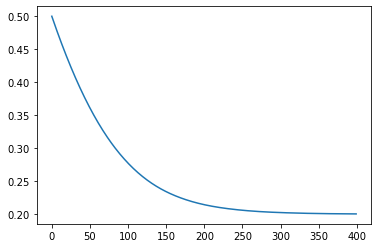

In [2]:
# simulated datasete
n = 1

def MMKinetics(t, x):
    Vmax, Km, k = 1.5, 0.3, 0.6
    return k - np.divide(Vmax*x, (Km+x))

tspan = np.linspace(0.01, 4, num=400)
dt = 0.01
ini = [0.5]
sol = integrate.solve_ivp(MMKinetics, [tspan[0], tspan[-1]], ini, method='RK45', t_eval=tspan)

plt.plot(sol.y[0])
plt.show()

## Library Generation

In [3]:
sol_dx = MMKinetics(sol.t, sol.y)
plt.show()
term_lib, term_des = lib_terms(sol.y, 6, "")
term_lib = np.hstack((term_lib, term_lib * sol_dx.T))

## System Identificiation

/Users/yiruichen/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in log
  


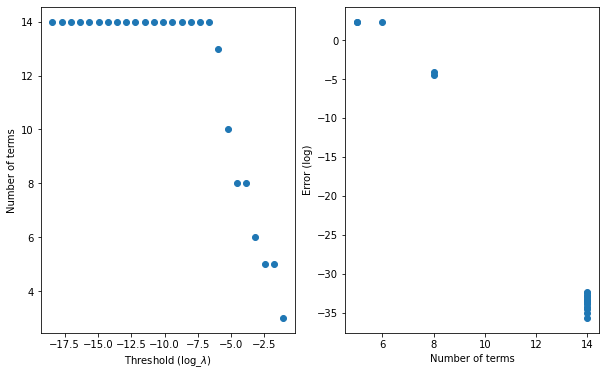

In [4]:
tol, pflag = 1e-5,1
dic_Xi, dic_lib, dic_lambda, dic_num, dic_error = ADMpareto(term_lib,tol)
lambda_vec = list(dic_lambda.values())
terms_vec = list(dic_num.values())
err_vec = list(dic_error.values())
log_err_vec = np.log(err_vec)
log_lambda_vec = np.log(lambda_vec)

# plot
plt.figure(figsize=(10,6))
plt.subplot(1,2,1)
plt.scatter(log_lambda_vec, terms_vec)
plt.xlabel("Threshold (log_$\lambda$)")
plt.ylabel("Number of terms")
plt.subplot(1,2,2)
plt.scatter(terms_vec, log_err_vec)
plt.xlabel("Number of terms")
plt.ylabel("Error (log)")
plt.show()

## Adding Noise and Denoising

In [5]:
#add noise to 'x'
eps = 1e-2  #float; magnitude of noise
SIZE = np.size(sol.y[0])
sol_noise=sol.y[0]+eps*np.random.normal(0,1,(SIZE))#np.size=400; shape=(1,400); type=numpy.ndarray
# #calculate the corresponding derivative
# sol_noise_dx = MMKinetics(sol.t, sol_noise)

In [6]:
#denoise
# create an order 3 lowpass butterworth filter
b, a = signal.butter(3, 0.05)
#first time
zi = signal.lfilter_zi(b, a)
z,_=signal.lfilter(b, a, sol_noise, zi=zi*sol_noise[0])
#second time
z2, _ = signal.lfilter(b, a, z, zi=zi*z[0])
#third time
y = signal.filtfilt(b, a, sol_noise)

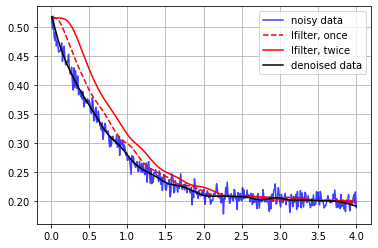

In [7]:
#plot noisy and denoised data
plt.figure
plt.plot( sol.t, sol_noise, 'b', alpha=0.75)
plt.plot( sol.t, z, 'r--', sol.t, z2, 'r', sol.t, y, 'k')
plt.legend(('noisy data', 'lfilter, once', 'lfilter, twice', 'denoised data'), loc='best')
plt.grid(True)
plt.show()

/Users/yiruichen/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in log
  


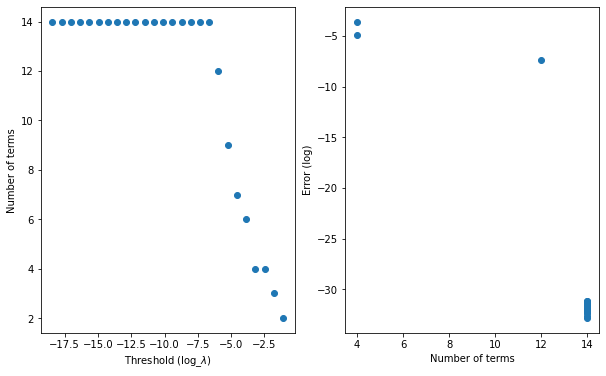

In [8]:
#denoised y and corresponding denoised dy
denoised_y=np.reshape(y,(1,len(y)))
denoised_dy = MMKinetics(sol.t, denoised_y)

term_lib, term_des = lib_terms(denoised_y, 6, "")
term_lib = np.hstack((term_lib, term_lib * denoised_dy.T))


tol, pflag = 1e-5,1
dic_Xi, dic_lib, dic_lambda, dic_num, dic_error = ADMpareto(term_lib,tol)
lambda_vec = list(dic_lambda.values())
terms_vec = list(dic_num.values())
err_vec = list(dic_error.values())
log_err_vec = np.log(err_vec)
log_lambda_vec = np.log(lambda_vec)

# plot
plt.figure(figsize=(10,6))
plt.subplot(1,2,1)
plt.scatter(log_lambda_vec, terms_vec)
plt.xlabel("Threshold (log_$\lambda$)")
plt.ylabel("Number of terms")
plt.subplot(1,2,2)
plt.scatter(terms_vec, log_err_vec)
plt.xlabel("Number of terms")
plt.ylabel("Error (log)")
plt.show()

In [9]:
print(lambda_vec)
print(terms_vec)

[1e-08, 2e-08, 4e-08, 8e-08, 1.6e-07, 3.2e-07, 6.4e-07, 1.28e-06, 2.56e-06, 5.12e-06, 1.024e-05, 2.048e-05, 4.096e-05, 8.192e-05, 0.00016384, 0.00032768, 0.00065536, 0.00131072, 0.00262144, 0.00524288, 0.01048576, 0.02097152, 0.04194304, 0.08388608, 0.16777216, 0.33554432]
[14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 12, 9, 7, 6, 4, 4, 3, 2]


In [10]:
dic_Xi[23]

array([ 0.12946984, -0.64712088,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        , -0.21578307, -0.71965748,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ])

## Identified System

In [11]:
##identified system
def newmm(t,x):
    k1, k2, k3, k4 = 0.129, -0.643, 0.215, 0.717
    return np.divide((k1 + k2*x), (k3 + k4*x))

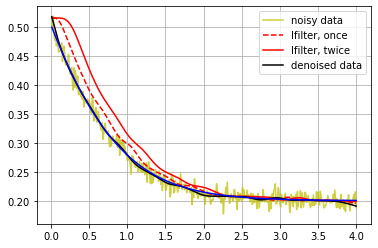

In [12]:
#plot identified data with denoised data
identified_y= integrate.solve_ivp(newmm, [tspan[0], tspan[-1]], ini, method='RK45', t_eval=tspan)
plt.figure
plt.plot(sol.t, sol_noise, 'y', alpha=0.75)
plt.plot(sol.t, z, 'r--', sol.t, z2, 'r', sol.t, y, 'k')
plt.plot(identified_y.t, identified_y.y[0], 'b')
plt.legend(('noisy data', 'lfilter, once', 'lfilter, twice', 'denoised data'), loc='best')
plt.grid(True)
plt.show()